# 1. 导入基本包，确定路径

In [25]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

In [2]:
plt.rcParams['figure.figsize'] = (8.0, 10.0)

In [8]:
dataDir= "datasets/balloon"
dataType="train"

annFile='{}/annotations/{}_coco.json'.format(dataDir,dataType)
print(f"标注文件位置：{annFile}")

标注文件位置：datasets/balloon/annotations/train_coco.json


In [9]:
!tree -L 4  --filelimit=10

.
├── datasets
│   ├── balloon
│   │   ├── annotation
│   │   │   ├── train_coco.json
│   │   │   └── val_coco.json
│   │   ├── train  [61 entries exceeds filelimit, not opening dir]
│   │   └── val  [13 entries exceeds filelimit, not opening dir]
│   ├── balloon_dataset.zip
│   └── cat_dataset.zip
└── pycocotools.ipynb

5 directories, 5 files


# 2.调用COCO API

初始化coco api对象用于实例标记

In [11]:
coco = COCO(annotation_file=annFile)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


coco读进来的就是个dict，所以按照dict格式去访问就可以了，dict里套list，查看对应属性值的类型去访问就ok了

In [99]:
from pprint import pprint
for key in coco.anns.keys():
    pprint(coco.anns[key])
    break

{'area': 246697,
 'bbox': [994, 619, 451, 547],
 'category_id': 0,
 'id': 0,
 'image_id': 0,
 'iscrowd': 0,
 'segmentation': [[1020.5,
                   963.5,
                   1000.5,
                   899.5,
                   994.5,
                   841.5,
                   1003.5,
                   787.5,
                   1023.5,
                   738.5,
                   1050.5,
                   700.5,
                   1089.5,
                   663.5,
                   1134.5,
                   638.5,
                   1190.5,
                   621.5,
                   1265.5,
                   619.5,
                   1321.5,
                   643.5,
                   1361.5,
                   672.5,
                   1403.5,
                   720.5,
                   1428.5,
                   765.5,
                   1442.5,
                   800.5,
                   1445.5,
                   860.5,
                   1441.5,
                  

## 2.1 查看类别

In [13]:
coco.getCatIds('balloon')
# 只有一个类别，所以id就是0

[0]

In [20]:
categorys = coco.loadCats(coco.getCatIds())
print(categorys, type(categorys),type(categorys[0]))
category_name = [category['name'] for category in categorys]
print(category_name)

# 如果有更高一级的分类，要查看超类的话，可以:(没有就是None)
supercategory_names = set([category.get('supercategory') for category in categorys])
print(f'COCO supercategories: {supercategory_names}')

[{'id': 0, 'name': 'balloon'}] <class 'list'> <class 'dict'>
['balloon']
COCO supercategories: {None}


## 2.2 选择查看某一类的图像

由于这里只有1类，所以就是示意了

In [21]:
catIds = coco.getCatIds(["balloon"])
print(f"balloon category id is: {catIds[0]}")
imgIds =coco.getImgIds(catIds=catIds)
print(f"train balloon image has {len(imgIds)}")

balloon category id is: 0
train balloon image has 61


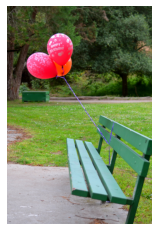

In [31]:
img = coco.loadImgs(ids=[10])[0]
img_name = img.get("file_name")
img_prefix = os.path.join(dataDir,dataType,img_name)

image=Image.open(img_prefix)
plt.axis('off')
plt.imshow(image)

## 2.3 查看图像及配套标注

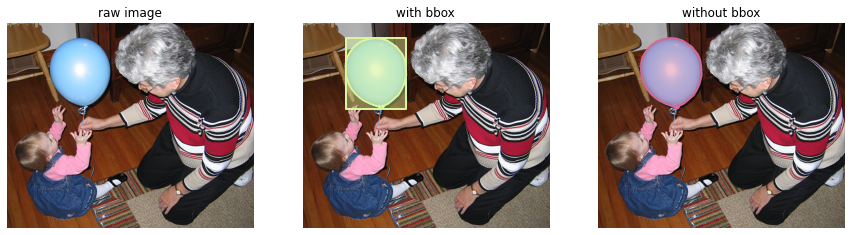

In [87]:
imgIds=[53]
img = coco.loadImgs(imgIds)[0]
img_name = img.get("file_name")
img_path = os.path.join(dataDir,dataType,img_name)
image=Image.open(img_path)

annsId = coco.getAnnIds(imgIds)
bbox = coco.loadAnns(annsId)[0]
type(bbox),bbox["bbox"]

plt.figure(figsize=(15,6))
plt.subplot(1,3,1)
plt.axis('off')
plt.title("raw image")
plt.imshow(image) 

plt.subplot(1,3,2)
plt.axis('off')
plt.title("with bbox")
plt.imshow(image) # 和图像一起显示
# 注意，coco里默认都是list格式，所以要显示单个的话，必须要加一层list
coco.showAnns([bbox],draw_bbox=True)

plt.subplot(1,3,3)
plt.axis('off')
plt.title("without bbox")
plt.imshow(image) # 和图像一起显示
coco.showAnns([bbox],draw_bbox=False)

还好这个气球标注数据有目标检测框，也有语义分割标注，还可以看看

In [44]:
annsId = coco.getAnnIds(imgIds=[10])
bbox = coco.loadAnns(annsId)[0]
type(bbox),bbox["bbox"]

(dict, [376, 257, 243, 324])

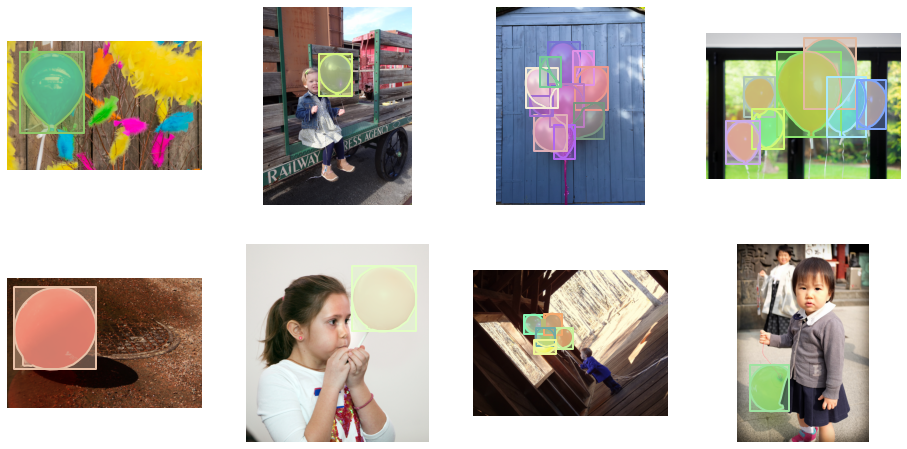

In [55]:
imgIds=[1,2,3,4,5,6,7,8]
plt.figure(figsize=(16,8))
for i in range(len(imgIds)):
    img = coco.loadImgs(imgIds[i])[0]
    img_name = img.get("file_name")
    img_path = os.path.join(dataDir,dataType,img_name)
    image=Image.open(img_path)

    annsId = coco.getAnnIds(imgIds[i])
    bbox = coco.loadAnns(annsId)
    plt.subplot(2,4,i+1)
    plt.axis('off')
    plt.imshow(image) # 和图像一起显示

    # 注意，coco里默认都是list格式，所以要显示单个的话，必须要加一层list
    coco.showAnns(bbox,draw_bbox=True)

如果是关键点和图像描述生成标注，也是使用`showAnns`这个函数去进行显示的。详见：[cocoapi/PythonAPI
/pycocoDemo.ipynb](https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocoDemo.ipynb)最下面部分

## 2.4 图像+标注+类别名称显示（需要优化）

如果想连带标签一起显示，花哨一点的话，就需要把数据拿出来，自己自定义一下了

In [70]:
from pycocotools.coco import COCO
import numpy as np
import os
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
import matplotlib.pyplot as plt
from PIL import Image

def show_bbox_only(coco,anns,show_label_bbox=True,is_filling=True):
    """Show bounding box of annotation Only"""
    if(len(anns)==0):
        return
    ax =plt.gca()
    ax.set_autoscale_on(False)

    image2color = dict()
    for cat in coco.getCatIds():
        image2color[cat]=(np.random.random((1,3))*0.7+0.3).tolist()[0]

    polygons=[]
    colors=[]

    for ann in anns:
        color = image2color[ann['category_id']]
        bbox_x,bbox_y,bbox_w,bbow_h = ann['bbox']
        # 构成多边形的顺时针
        poly = [[bbox_x,bbox_y],[bbox_x+bbox_w,bbox_y],[bbox_x+bbox_w,bbox_y+bbow_h],[bbox_x,bbox_y+bbow_h]]
        # 逆时针
        # poly = [[bbox_x,bbox_y],[bbox_x,bbox_y+bbow_h],[bbox_x+bbox_w,bbox_y+bbow_h],[bbox_x+bbox_w,bbox_y]]
        polygons.append(Polygon(np.array(poly).reshape((4,2))))
        colors.append(color)
    if show_label_bbox:
        label_box = dict(facecolor=color)
    else:
        label_box = None
    ax.text(bbox_x,bbox_y,f"{coco.loadCats(ann['category_id'])[0]['name']}",color='white',bbox=label_box)
    if is_filling:
        p=PatchCollection(polygons,facecolor=colors,linewidth=0,alpha=0.4)
        ax.add_collection(p)

In [73]:
import numpy as np
(np.random.random((1,3))*0.7+0.3).tolist()[0]

[0.7111356407273306, 0.5502573158722894, 0.39132797928593444]

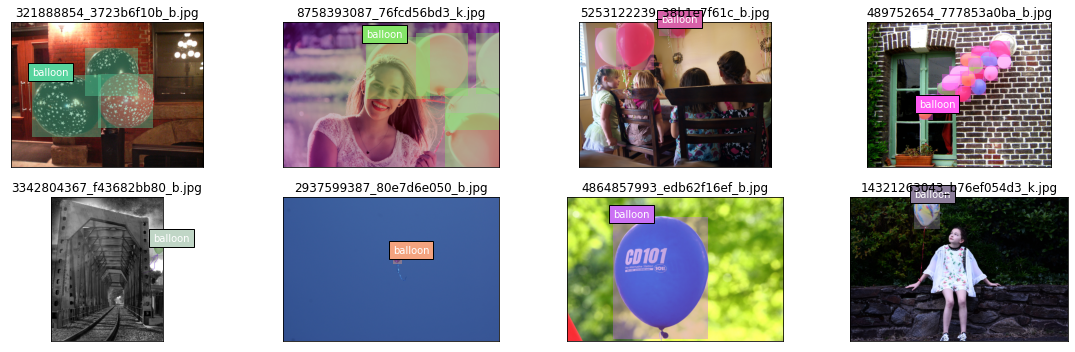

In [72]:
import os

image_ids=coco.getImgIds()
np.random.shuffle(image_ids)

plt.figure(figsize=(16,5))
for i in range(8):
    image_data=coco.loadImgs(image_ids[i])[0]
    img_path = os.path.join(dataDir,dataType,image_data.get("file_name"))

    annotation_ids = coco.getAnnIds(imgIds=image_data['id'])
    annotation = coco.loadAnns(annotation_ids)

    ax=plt.subplot(2,4,i+1)
    image = Image.open(img_path)

    ax.imshow(image)
    show_bbox_only(coco,annotation,)
    plt.title(image_data["file_name"])
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

+ 可以看到，上面的`show_bbox_only`中的`is_filling=True`是填充bbox的，和分割的那个填充有区别
+ 如果想得到和cooc.showAnns里分割一样的效果，需要对上面的代码进行修改

# 3. 调用eval来评估模型效果

## 3.1 结果的格式

详见：[Results Format](https://cocodataset.org/#format-results)

Object Detection的格式(bbox)：
```json
[{
"image_id": int, 
"category_id": int, 
"bbox": [x,y,width,height], 
"score": float,
}]

```
Object Detection的格式(segmentation)：
```json
[{
"image_id": int, 
"category_id": int, 
"segmentation": RLE, 
"score": float,
}]
```
如果格式还是有问题的话，可以看看这里提供的结果示例：<https://github.com/cocodataset/cocoapi/blob/master/results/instances_val2014_fakebbox100_results.json>

这个的做法很原始，把**真值的coco_format.json**文件和**模型预测结果的coco_format.json**送进去计算就可以了

## 3.2 调用代码

In [98]:
from pycocotools.cocoeval import COCOeval
import os

dataDir= "datasets/balloon"
dataType="train"

annFile='{}/annotations/{}_coco.json'.format(dataDir,dataType)
print(f"标注文件位置：{annFile}")

# 先规定标注类型，还可以有segmentation,keypoints
annType = 'bbox'

# 用真值json创建coco对象，使用loadRes加载预测json
cocoGt=COCO(annFile)
# 使用loadRes加载预测json，这里直接造了个假的
cocoPred =cocoGt.loadRes("datasets/balloon/annotations/val_coco_result.json")

# 选择需要比较的图像id
imgIds=sorted(cocoGt.getImgIds())
imgId = [0] # 我造的假数据里只有0

# running evaluation
cocoEval = COCOeval(cocoGt,cocoPred,annType)
cocoEval.params.imgIds  = imgIds
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

标注文件位置：datasets/balloon/annotations/train_coco.json
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Reca

In [88]:
np.random.randint(100)

56

# 4. 构建符合COCO格式的数据集

上面使用的气球数据集，是[Mask_RCNN官方repo](https://github.com/matterport/Mask_RCNN)提供的一个demo数据集，用来演示如何配合自己的数据集训练mark_rcnn
+ 下载地址在这里：<https://github.com/matterport/Mask_RCNN/releases>
+ 文章：[Splash of Color: Instance Segmentation with Mask R-CNN and TensorFlow](https://engineering.matterport.com/splash-of-color-instance-segmentation-with-mask-r-cnn-and-tensorflow-7c761e238b46)
+ 中文可以看看：[6.8 Mask RCNN分割案例](https://note.zbmain.com/ainote/deeplearning/imageSegmentation/section7.html)

这个数据集是使用标注工具[VIT（VGG-Image-Annotator)](https://www.robots.ox.ac.uk/~vgg/software/via/via_demo.html)标注的
+ 似乎常见的数据集里只有这个气球数据集是用这个VIT标注的，其他的根本没有这个格式。。。
+ 后续这个VIT在线标注工具也支持导出COCO格式数据集，但是好像没什么人用了

这个VIT的标注格式是：
```json
"24631331976_defa3bb61f_k.jpg668058":
{"fileref":"",
 "size":668058,
 "filename":"24631331976_defa3bb61f_k.jpg",
 "base64_img_data":"",
 "file_attributes":{},
 "regions":{
     "0":{
         "shape_attributes":
         {"name":"polygon",
          "all_points_x":[916,913,905,889,868,836,809,792,789,784,777,769,767,777,786,791,769,739,714,678,645,615,595,583,580,584,595,614,645,676,716,769,815,849,875,900,916,916],
          "all_points_y":[515,583,616,656,696,737,753,767,777,785,785,778,768,766,760,755,755,743,728,702,670,629,588,539,500,458,425,394,360,342,329,331,347,371,398,442,504,515]},
         "region_attributes":{}}}},

```
结合coco的格式，其实我们需要的只有
```json
image{
    "id": int,
    "width": int,
    "height": int,
    "file_name": str,
}

annotation{
    "id": int,
    "image_id": int,
    "segmentation": RLE or [polygon
    ],
    "area": float,
    "bbox": [x,y,width,height
    ],
    "iscrowd": 0 or 1,
    // iscrowd是1，表示要使用RLE
}

categories[
    {
        "id": int,
        "name": str,
    }
]
```

参考：
+ [TommyZihao/MMDetection_Tutorials/mmdet-0829/【E2】气球数据集 (2).ipynb](https://github.com/TommyZihao/MMDetection_Tutorials/blob/main/mmdet-0829/%E3%80%90E2%E3%80%91%E6%B0%94%E7%90%83%E6%95%B0%E6%8D%AE%E9%9B%86%20(2).ipynb)
+ [使用MMDetection3.x 在Balloon气球数据集上训练并对视频进行实例分割和制作成Color Splash效果](https://zhuanlan.zhihu.com/p/606610273)

上面用的代码里关于area的计算有些争议：
+ [Understanding COCO Dataset](https://www.section.io/engineering-education/understanding-coco-dataset/)
+ 根据["area" in annotations #36](https://github.com/cocodataset/cocoapi/issues/36):
    1. 这里的area指的是bbox的大小，计算IoU参数那些的时候会用到，也可以用来区分大中小bbox
    2. 是bbox高宽的乘积，用来划分bbox的范围。
    3. 但是这个问题也提到，如果要计算segmentation area，可以调用[cocoapi/PythonAPI/pycocotools
/mask.py](https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocotools/mask.py#L35)的`area`函数

另外，这个代码用到了mmopenlab系列的库，用起来会有些不方便，改掉

In [109]:
import os.path as osp
import json
import cv2

image_base_dir = "datasets/balloon/val"
ann_file_path = 'datasets/balloon/val_raw.json'
with open(ann_file_path,"r",encoding='utf8') as f:
    labelDict=f.readline()
label=json.loads(labelDict)
labelDict=dict(label)
labelDict.keys()

dict_keys(['24631331976_defa3bb61f_k.jpg668058', '16335852991_f55de7958d_k.jpg1767935', '14898532020_ba6199dd22_k.jpg1803855', '8053085540_a72bd21a64_k.jpg844432', '6810773040_3d81036d05_k.jpg875646', '5603212091_2dfe16ea72_b.jpg337278', '5555705118_3390d70abe_b.jpg147544', '4838031651_3e7b5ea5c7_b.jpg269213', '4581425993_72b9b15fc0_b.jpg329032', '3825919971_93fb1ec581_b.jpg328049', '3800636873_ace2c2795f_b.jpg194209', '2917282960_06beee649a_b.jpg381043', '410488422_5f8991f26e_b.jpg129652'])

In [120]:
annotations=[]
images=[]
categories=[{"id":0,"name":"balloon"}]

images_id =0
anno_id=0
for key,value in labelDict.items():
    one_instance = labelDict[key]
    # print(one_instance)
    file_name = one_instance["filename"]
    
    # 通过读取图像获取图像的高宽
    img_path = os.path.join(image_base_dir,file_name)
    image=cv2.imread(img_path)
    height,width = image.shape[:2]
    print(height,width)
    
    images.append({"id":images_id,"width":width,"height":height,"file_name":file_name})
    
    # 找出x和y序列中的最值，作为bbox, 
    # bbox的height*width=area
    # x_1,y_1,x_2,y_2..就是segmentation了
    for region_key,region_value in one_instance["regions"].items():
        print(region_key,region_value)
        
    images_id+=1
    break

2048 1323
0 {'shape_attributes': {'name': 'polygon', 'all_points_x': [916, 913, 905, 889, 868, 836, 809, 792, 789, 784, 777, 769, 767, 777, 786, 791, 769, 739, 714, 678, 645, 615, 595, 583, 580, 584, 595, 614, 645, 676, 716, 769, 815, 849, 875, 900, 916, 916], 'all_points_y': [515, 583, 616, 656, 696, 737, 753, 767, 777, 785, 785, 778, 768, 766, 760, 755, 755, 743, 728, 702, 670, 629, 588, 539, 500, 458, 425, 394, 360, 342, 329, 331, 347, 371, 398, 442, 504, 515]}, 'region_attributes': {}}


In [ ]:
import os.path as osp

import mmcv

from mmengine.fileio import dump, load
from mmengine.utils import track_iter_progress


def convert_balloon_to_coco(ann_file, out_file, image_prefix):
    data_infos = load(ann_file)

    annotations = []
    images = []
    obj_count = 0
    for idx, v in enumerate(track_iter_progress(data_infos.values())):
        filename = v['filename']
        img_path = osp.join(image_prefix, filename)
        height, width = mmcv.imread(img_path).shape[:2]

        images.append(
            dict(id=idx, file_name=filename, height=height, width=width))

        for _, obj in v['regions'].items():
            assert not obj['region_attributes']
            obj = obj['shape_attributes']
            px = obj['all_points_x']
            py = obj['all_points_y']
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            x_min, y_min, x_max, y_max = (min(px), min(py), max(px), max(py))

            data_anno = dict(
                image_id=idx,
                id=obj_count,
                category_id=0,
                bbox=[x_min, y_min, x_max - x_min, y_max - y_min],
                area=(x_max - x_min) * (y_max - y_min),
                segmentation=[poly],
                iscrowd=0)
            annotations.append(data_anno)
            obj_count += 1

    coco_format_json = dict(
        images=images,
        annotations=annotations,
        categories=[{
            'id': 0,
            'name': 'balloon'
        }])
    dump(coco_format_json, out_file)


# convert_balloon_to_coco(ann_file='/content/balloon_dataset/balloon/train.json',
#             out_file='/content/balloon_dataset/balloon/train_coco.json',
#             image_prefix='/content/balloon_dataset/balloon/train')
# convert_balloon_to_coco(ann_file='/content/balloon_dataset/balloon/val.json',
#             out_file='/content/balloon_dataset/balloon/val_coco.json',
#             image_prefix='/content/balloon_dataset/balloon/val')